In [241]:
import numpy as np
import pandas as pd

from astropy.time import Time, TimeDelta
from astropy.coordinates import EarthLocation
from astropy import units as u
from astroplan import (FixedTarget, Observer, 
                       AltitudeConstraint, AtNightConstraint, 
                       MoonSeparationConstraint)

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

from datetime import datetime

On définit une fonction contraintes, basé sur les librairies astropy et astroplan, qui nous permet de connaître les dates auxquelles il est possible d'observer une certaine phase de notre étoile en fonction de contraintes que l'on souhaite imposer : 

    -Il fait nuit    
    -L'étoile est à un angle supérieur à 30° de l'horizon    
    -L'étoile est à une distance angulaire supérieure à 30° de la lune

On entre les coordonnées de l'observatoire (New mexico skies), ainsi que le nom de l'étoile que l'on souhaite observer, puis l'on crée un tableau au format Time qui contient les 'amount' prochaines dates auxquelles l'étoile est aux différentes phases demandées. On vérifie en même temps que les contraintes soient respectées.
Si les contraintes sont respectées, la date est conservée. Sinon, elle est supprimée.
On renvoit un tableau au format DataFrame qui contient des colonnes correspondant aux différentes phases que l'on souhaite observer, et pour lesquelles on a une succession de dates d'observation possible.

In [196]:
def constraintes(amount, minimum, periode, phases) :
    
    #On définit les données relatives à l'observatoire et à notre étoile
    T5 = EarthLocation(lat = 32.9 * u.deg, lon = -105.5 * u.deg, height = 2225 * u.m)
    observatoire = Observer(location = T5, name = "T5")
    target = FixedTarget.from_name("DU BOO")
    
    #On définit nos contraintes
    constraints = [AtNightConstraint.twilight_astronomical(),
                  MoonSeparationConstraint(min = 30 *u.deg),
                  AltitudeConstraint(min = 30* u.deg)]
    
    #On convertit les entrée au format Time
    start_min = Time(minimum, format = 'jd')
    period = TimeDelta(periode, format = 'jd')
    
    #On crée un tableau vide au format Time, et un tableau correspondant qui contiendra l'information
    #sur les contraintes
    time = Time(np.ones((amount, len(phases))), format = 'jd')
    ok = np.zeros_like(time)
    
    #On vérifie les contraintes
    for n in range (amount) :
        time[n] = start_min + periode * (phases + n)
        
        ok[n] = np.logical_and(constraints[0](observatoire, target, times = time[n]) == True, 
                               np.logical_and(constraints[1](observatoire, target, times = time[n]) == True,
                                              constraints[2](observatoire, target, times = time[n]) == True))
    
    #On se replace à l'heure = UTC - 7
    time = time - 7 * u.hour
    
    #On extrait un array de notre tableau time, au format de dates iso
    time_obs = time.iso
    
    #On transforme l'array en un dataFrame
    df = pd.DataFrame(data=time_obs, columns=phases)
    
    #On supprime les entrées la où les contraintes ne sont pas respectées    
    df = df.where(ok != False)
    
    return df
    


Afin de déterminer les phases que l'on souhaite observer, on utilise les données disponible sur [le site de l'université de strasbourg]('http://cdsarc.u-strasbg.fr/viz-bin/vizExec/Vgraph?I/239/70240&P=1.0558882&P=1.0558882')
On trace un graphique de ces données, que l'on décale afin de placer le début de la période au milieu du minimum principal de luminosité. On place ensuite les 15 points d'observations, d'abord en séparant uniformément la période, puis en ajustant afin d'avoir des points coincidant avec les maximas et minimas.
On a alors la liste des phases que l'on souhaite observer

In [215]:
lum = pd.read_csv('data/luminosite', delimiter = ' ', skiprows = 6, header = None,
                   names = ['phase', '', 'luminosite', 'erreur'])
lum.head()

,phase,,luminosite,erreur
0,0.239611,NaN,8.7616,0.018
1,0.582669,NaN,8.6570,0.017
2,0.596250,NaN,8.6454,0.017
3,0.666863,NaN,8.5992,0.015
4,0.279503,NaN,8.7985,0.012


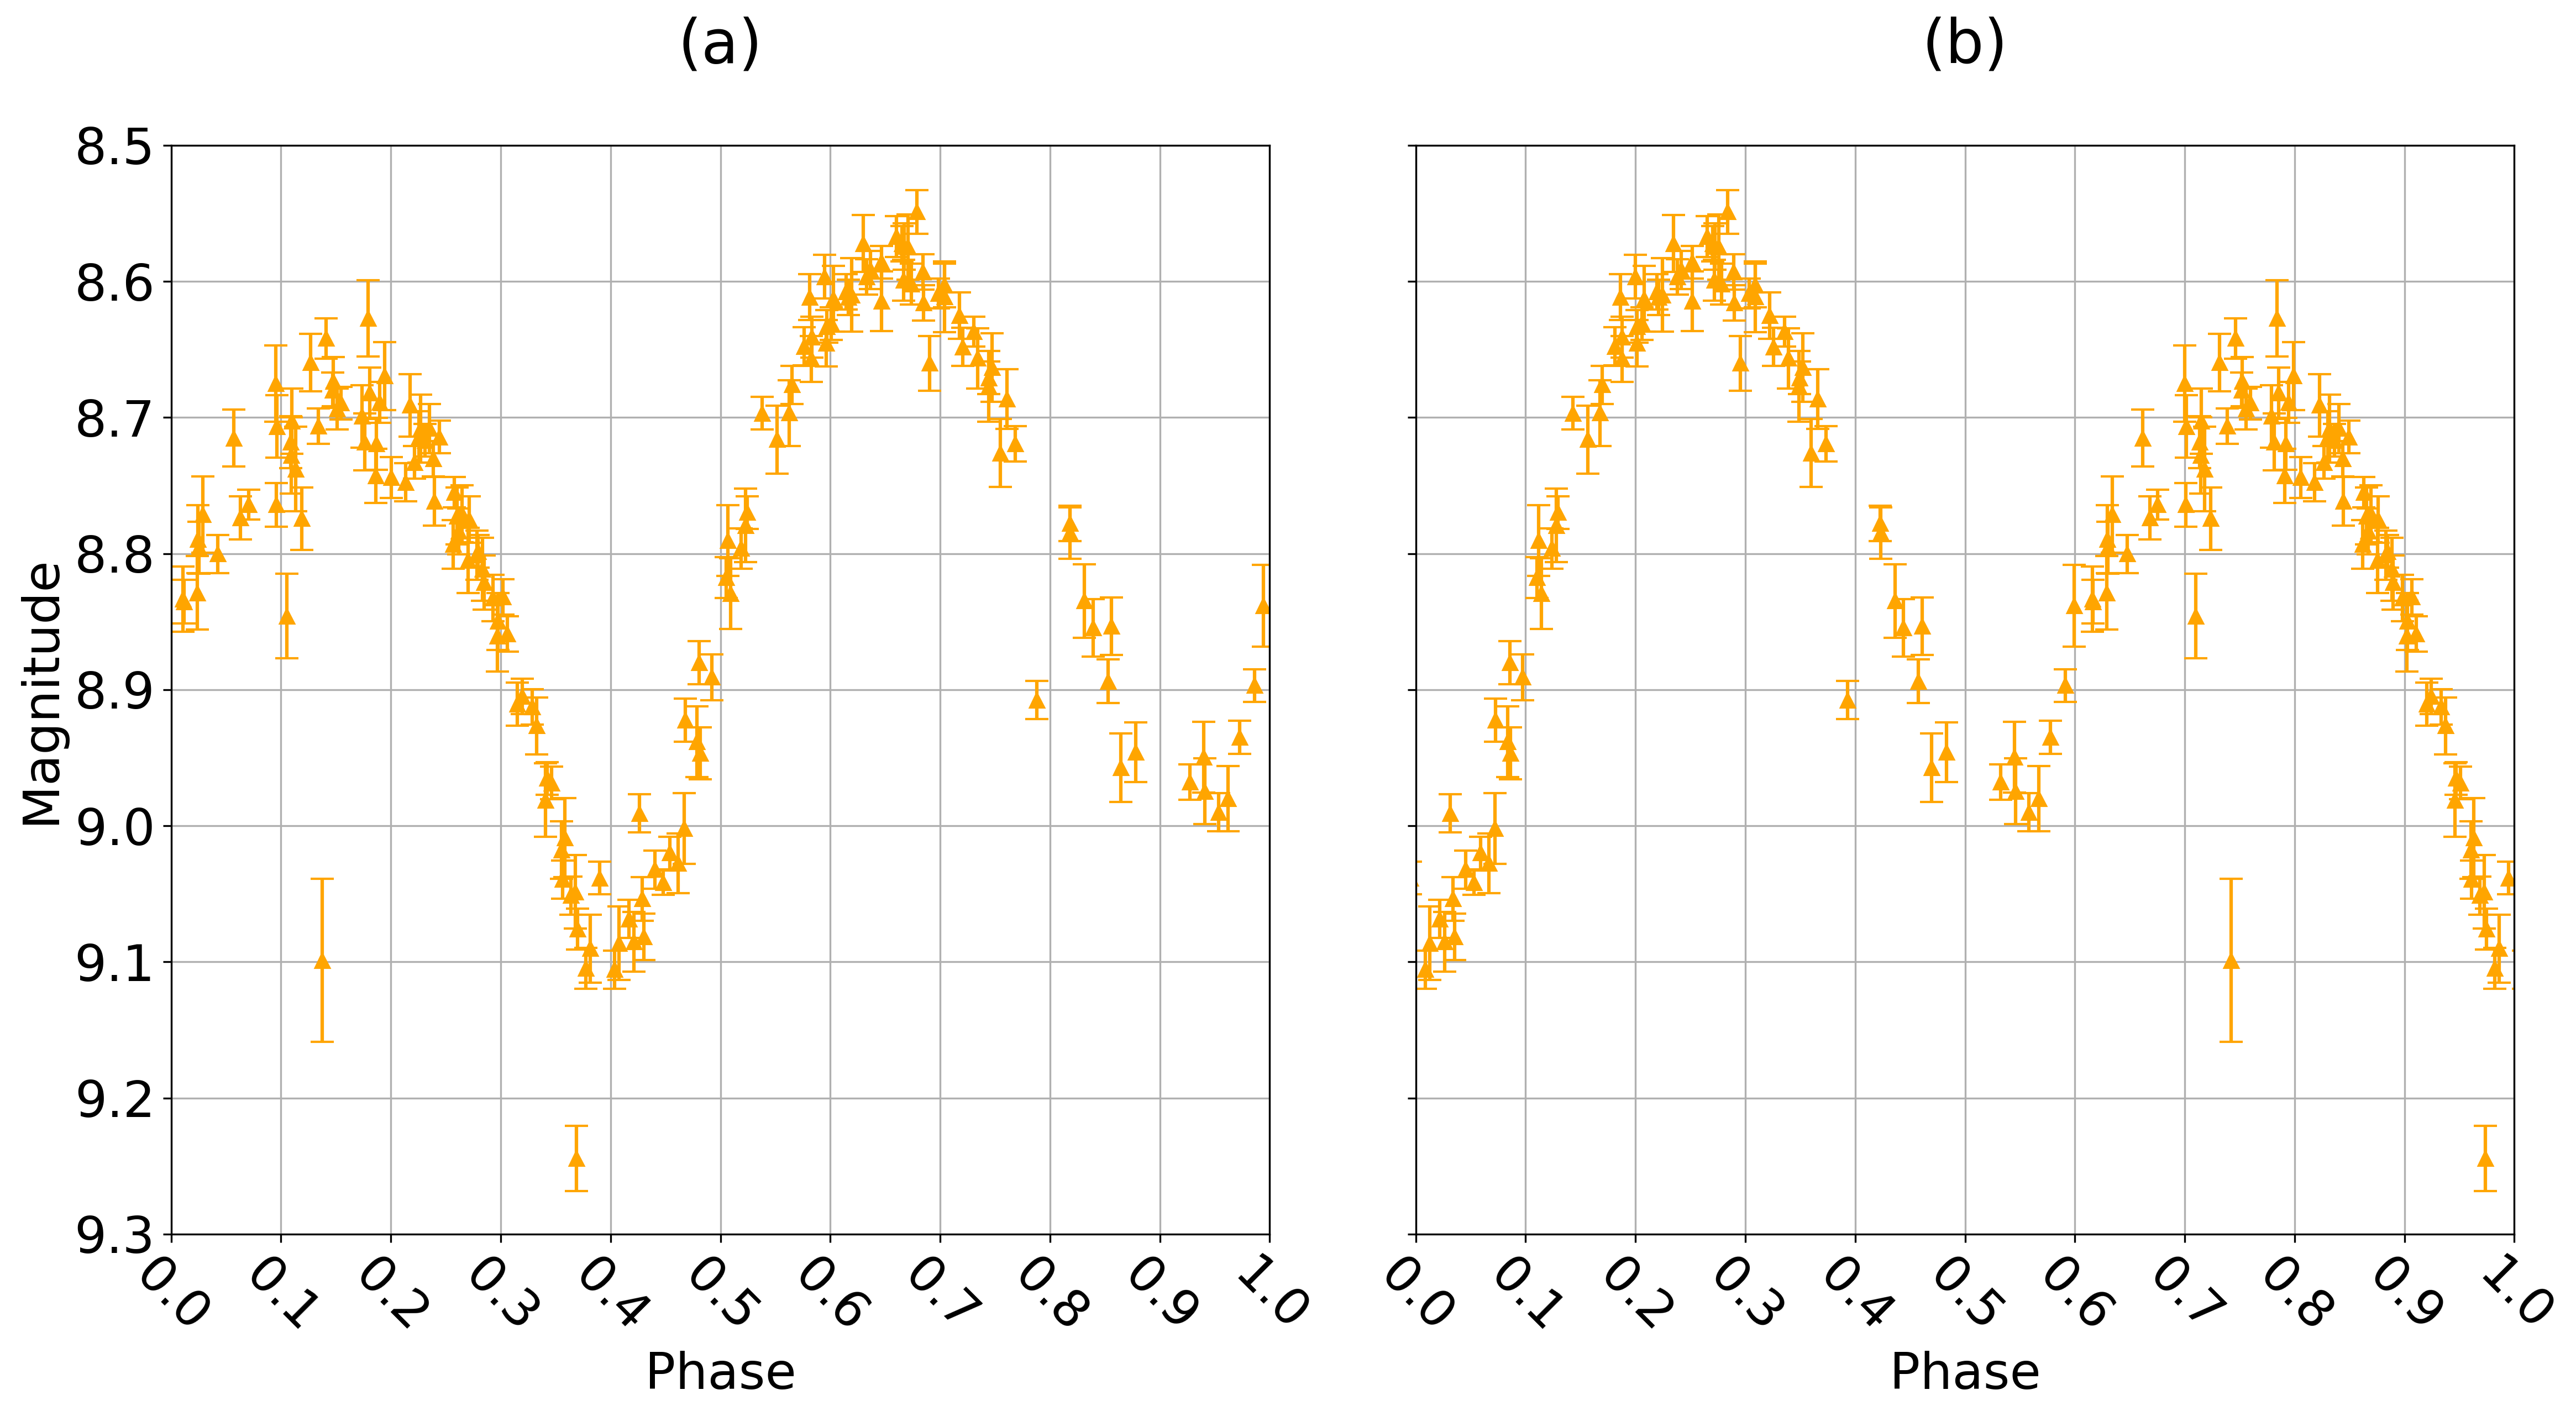

In [242]:

fig, ax = plt.subplots(1, 2, dpi = 300, figsize = (16, 9), sharey = True)

xticks = np.around(np.linspace(0, 1, 11), 1)

ax[0].set_title('(a)\n')

ax[0].errorbar(lum['phase'], lum['luminosite'], fmt = '^', yerr = lum['erreur'],
            capsize = 5, c = 'orange')

ax[0].set_xticks(xticks)
ax[0].set_xticklabels(xticks, rotation = -45)
ax[0].grid(which = 'both')

ax[0].set_xlim(0, 1)
ax[0].set_xlabel('Phase')

ax[0].set_ylim(8.5, 9.3)
ax[0].set_ylabel('Magnitude')
ax[0].invert_yaxis()


ax[1].set_title('(b)\n')

ax[1].errorbar(lum['phase'] + (1- 0.395), lum['luminosite'], fmt = '^', yerr = lum['erreur'],
            capsize = 5,  c ='orange')
ax[1].errorbar(lum['phase'] - 0.395, lum['luminosite'], fmt = '^', yerr = lum['erreur'],
            capsize = 5, c = 'orange')

ax[1].set_xticks(xticks)
ax[1].set_xticklabels(xticks, rotation = -45)
ax[1].grid(which = 'both')

ax[1].set_xlim(0, 1)
ax[1].set_xlabel('Phase')

ax[1].set_ylim(8.5, 9.3)
ax[1].invert_yaxis()

fig.tight_layout()

fig.savefig('figures/cds_luminosite_centree.png')

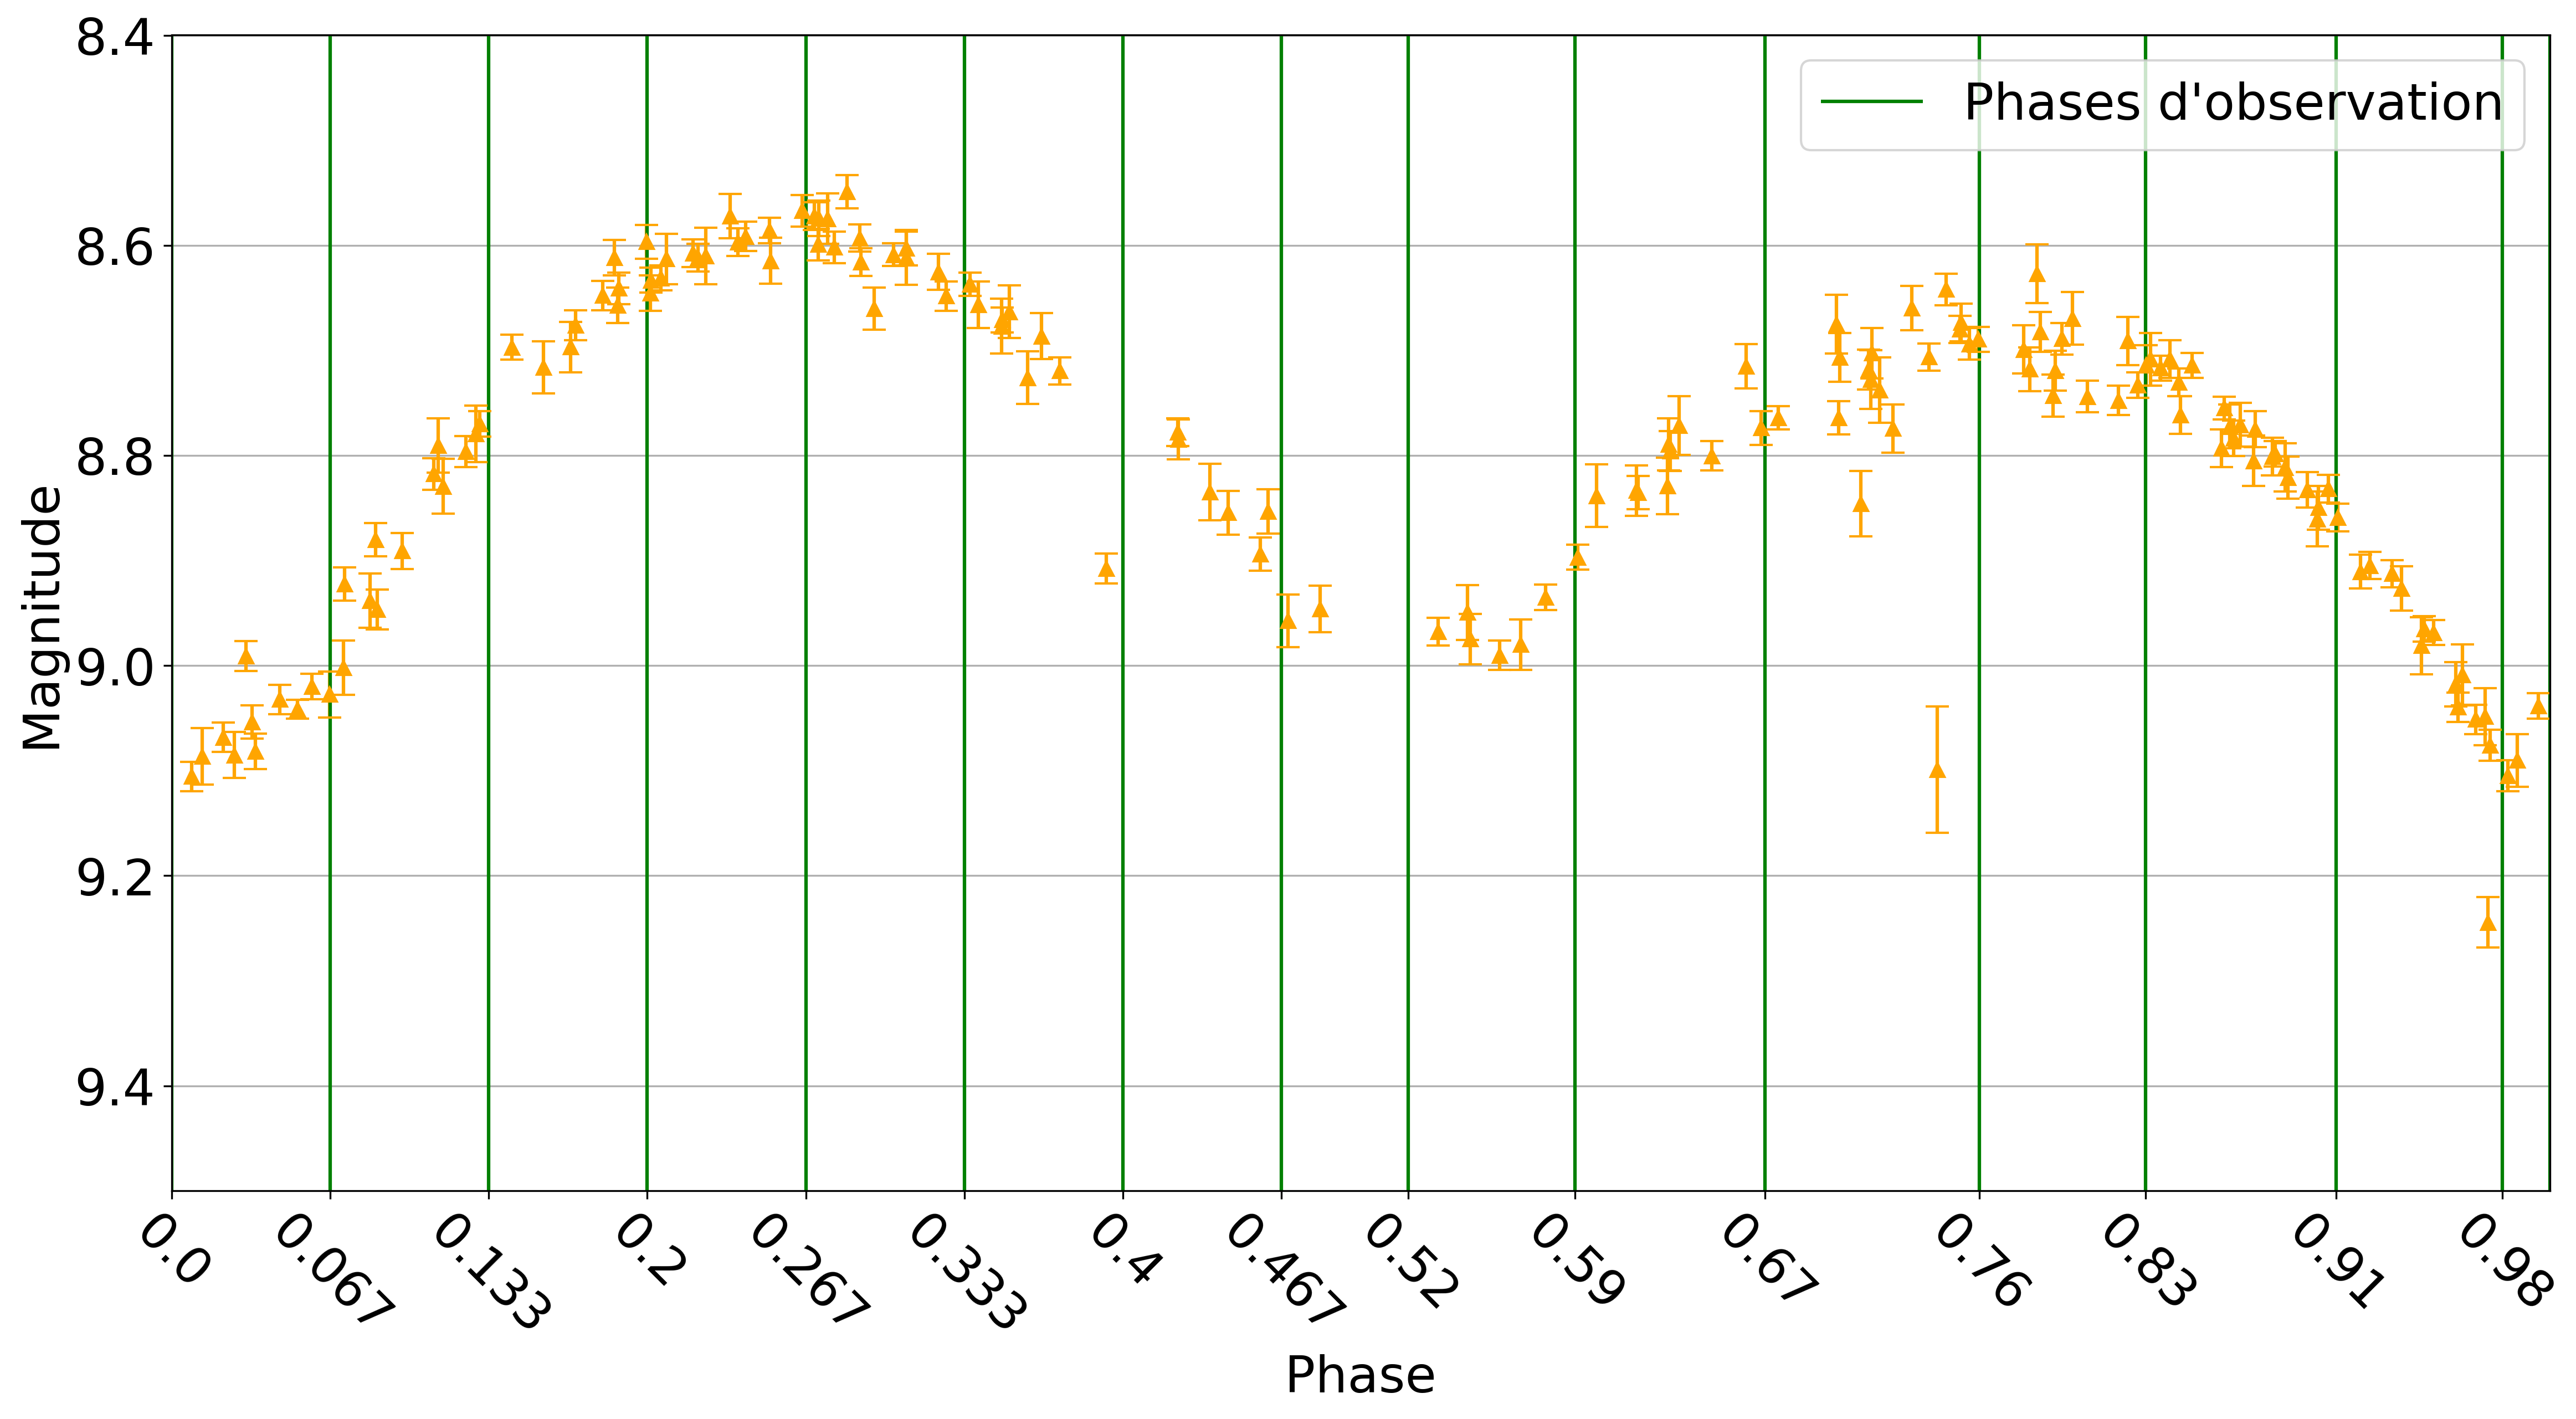

In [227]:

phases = np.linspace(0, 1, 16)
phases[-8:] = [0.52 , 0.59, 0.67,0.76, 0.83, 0.91, 0.98, 1.0]


fig, ax = plt.subplots(1, 1, dpi = 300, figsize = (16, 9))




ax.errorbar(lum['phase']+ (1 - 0.395), lum['luminosite'], fmt = '^', yerr = lum['erreur'],
            capsize = 5,  c ='orange')
ax.errorbar(lum['phase'] - 0.395, lum['luminosite'], fmt = '^', yerr = lum['erreur'],
            capsize = 5, c = 'orange')
ax.vlines(phases, 8.4, 9.5, color = 'g', label = 'Phases d\'observation')




ax.set_xlim(0, 1)
ax.set_xlabel('Phase')

ax.set_ylim(8.4, 9.5)
ax.set_ylabel('Magnitude')
ax.invert_yaxis()

ax.set_xticks(phases[0:-1])
ax.set_xticklabels(np.around(phases[0:-1], 3), rotation = -45)
ax.grid()

ax.legend()

fig.tight_layout()

fig.savefig('figures/cds_luminosite_centree_phases')

On initialise une variable contenant la période de l'étoile variable, ainsi qu'une variable contenant la date en jour julien correspondant au milieu de son minimum de luminosité, d'après l'éphéméride [disponible ici]('https://www.aavso.org/vsx/index.php?view=detail.ephemeris&nolayout=1&oid=4446' "aavso")
De plus, on crée un array contenant les différentes phases de l'étoile que l'on souhaite observer. Il faut noter que le début de la période est ici choisie en le minimum de luminosité de l'étoile.

On envoie alors ces données dans notre fonction contraintes(), qui nous renvoie un tableau au format DataFrame, contenant une liste de dates pour lesquelles les contraintes que l'on a choisies sont respectées.
Attention les dates sont à l'heure locale ! UTC - 7

In [221]:
minimum = 2458893.438
periode = 1.0558882

#On avance dans le temps jusqu'à ce que la date indiqué pour le minimum soit postérieure à la date
#actuelle
today = Time(datetime.utcnow(), format = 'datetime')
while minimum < today.jd :
    minimum = minimum + periode
    
dates = constraintes(50, minimum, periode, phases)
dates.head()

Il y a beaucoup de trous dans ce tableau. La cellule suivante permet de le nettoyer, et de supprimer toutes les entrées nulles.

In [210]:
data = []
for i,phase in enumerate(list(dates)) :
    data.append(dates[phase].dropna().values.tolist())

dates_sort = pd.DataFrame(data = data, index = np.around(phases, 3))
dates_sort = dates_sort.transpose()
dates_sort

,0.000,0.067,0.133,0.200,0.267,0.333,0.400,0.467,0.520,0.590,0.670,0.760,0.830,0.910,0.980,1.000
0,2020-02-23 03:35:01.864,2020-03-07 22:42:37.407,2020-03-06 23:03:30.582,2020-03-05 23:24:23.758,2020-03-04 23:45:16.933,2020-03-02 22:45:41.368,2020-03-01 23:06:34.544,2020-02-29 23:27:27.720,2020-02-28 23:28:04.512,2020-02-27 23:54:01.783,2020-02-25 23:14:42.602,2020-02-25 00:11:04.448,2020-02-24 00:37:01.719,2020-02-24 02:38:40.018,2020-02-24 04:25:06.030,2020-02-24 04:55:30.605
1,2020-02-24 04:55:30.605,2020-03-09 00:03:06.147,2020-03-08 00:23:59.323,2020-03-07 00:44:52.498,2020-03-06 01:05:45.674,2020-03-04 00:06:10.109,2020-03-03 00:27:03.284,2020-03-02 00:47:56.460,2020-03-01 00:48:33.252,2020-02-29 01:14:30.524,2020-02-27 00:35:11.342,2020-02-26 01:31:33.188,2020-02-25 01:57:30.460,2020-02-25 03:59:08.759,2020-03-09 23:11:48.397,2020-03-08 22:21:44.231
2,2020-03-08 22:21:44.231,2020-03-10 01:23:34.888,2020-03-09 01:44:28.063,2020-03-08 02:05:21.239,2020-03-07 02:26:14.414,2020-03-05 01:26:38.849,2020-03-04 01:47:32.025,2020-03-03 02:08:25.201,2020-03-02 02:09:01.993,2020-03-01 02:34:59.264,2020-02-28 01:55:40.083,2020-02-27 02:52:01.929,2020-02-26 03:17:59.200,2020-03-10 22:45:51.126,2020-03-11 00:32:17.137,2020-03-09 23:42:12.972
3,2020-03-09 23:42:12.972,2020-03-11 02:44:03.628,2020-03-10 03:04:56.804,2020-03-09 03:25:49.979,2020-03-08 03:46:43.155,2020-03-06 02:47:07.590,2020-03-05 03:08:00.765,2020-03-04 03:28:53.941,2020-03-03 03:29:30.733,2020-03-02 03:55:28.005,2020-02-29 03:16:08.823,2020-02-28 04:12:30.669,2020-02-27 04:38:27.941,2020-03-12 00:06:19.866,2020-03-12 01:52:45.878,2020-03-11 01:02:41.712
4,2020-03-11 01:02:41.712,2020-03-12 04:04:32.369,2020-03-11 04:25:25.544,2020-03-10 04:46:18.720,2020-03-22 22:33:25.522,2020-03-07 04:07:36.330,2020-03-06 04:28:29.506,2020-03-05 04:49:22.681,2020-03-04 04:49:59.474,2020-03-16 22:42:10.371,2020-03-01 04:36:37.563,2020-03-13 22:59:13.036,2020-03-11 22:04:41.567,2020-03-13 01:26:48.606,2020-03-13 03:13:14.618,2020-03-12 02:23:10.453
5,2020-03-12 02:23:10.453,2020-03-25 21:30:45.995,2020-03-24 21:51:39.170,2020-03-23 22:12:32.346,2020-03-23 23:53:54.262,2020-03-20 21:33:49.957,2020-03-19 21:54:43.132,2020-03-18 22:15:36.308,2020-03-17 22:16:13.100,2020-03-18 00:02:39.112,2020-03-14 22:02:51.190,2020-03-15 00:19:41.776,2020-03-12 23:25:10.307,2020-03-14 02:47:17.347,2020-03-14 04:33:43.359,2020-03-13 03:43:39.193
6,2020-03-13 03:43:39.193,2020-03-26 22:51:14.735,2020-03-25 23:12:07.911,2020-03-24 23:33:01.086,2020-03-25 01:14:23.003,2020-03-21 22:54:18.697,2020-03-20 23:15:11.873,2020-03-19 23:36:05.048,2020-03-18 23:36:41.841,2020-03-19 01:23:07.852,2020-03-15 23:23:19.930,2020-03-16 01:40:10.517,2020-03-14 00:45:39.048,2020-03-15 04:07:46.087,2020-03-27 21:59:56.985,2020-03-26 21:09:52.819
7,2020-03-26 21:09:52.819,2020-03-28 00:11:43.476,2020-03-27 00:32:36.651,2020-03-26 00:53:29.827,2020-03-26 02:34:51.743,2020-03-23 00:14:47.438,2020-03-22 00:35:40.613,2020-03-21 00:56:33.789,2020-03-20 00:57:10.581,2020-03-20 02:43:36.593,2020-03-17 00:43:48.671,2020-03-17 03:00:39.257,2020-03-15 02:06:07.788,2020-03-28 21:33:59.714,2020-03-28 23:20:25.725,2020-03-27 22:30:21.560
8,2020-03-27 22:30:21.560,2020-03-29 01:32:12.216,2020-03-28 01:53:05.392,2020-03-27 02:13:58.567,2020-03-27 03:55:20.483,2020-03-24 01:35:16.178,2020-03-23 01:56:09.354,2020-03-22 02:17:02.529,2020-03-21 02:17:39.322,2020-03-21 04:04:05.333,2020-03-18 02:04:17.411,2020-03-18 04:21:07.998,2020-03-16 03:26:36.529,2020-03-29 22:54:28.454,2020-03-30 00:40:54.466,2020-03-28 23:50:50.300
9,2020-03-28 23:50:50.300,2020-03-30 02:52:40.957,2020-03-29 03:13:34.132,2020-03-28 03:34:27.308,2020-04-09 21:21:34.110,2020-03-25 02:55:44.919,2020-03-24 03:16:38.094,2020-03-23 03:37:31.270,2020-03-22 03:38:08.062,2020-04-03 21:30:18.960,2020-03-19 03:24:46.152,2020-03-31 21:47:21.624,2020-03-29 20:52:50.155,2020-03-31 00:14:57.195,2020-03-31 02:01:23.206,2020-03-30 01:11:19.041


 On exporte ensuite notre tableau au format csv, pour pouvoir ensuite le lire facilement sur n'importe quel tableur, ou réimporter facilement le fichier dans python

In [207]:
dates_sort.to_csv('data/dates.csv')